In [1]:
import os
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true' #GPU 사용시 초기 메모리를 작게하여 OOM 방지하기 위한 목적
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, concatenate
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)

    def get_angles(self, position, i, d_model):
        angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return position * angles

    def positional_encoding(self, position, d_model):
        angle_rads = self.get_angles(
            position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
            i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
            d_model=d_model)

        # 배열의 짝수 인덱스(2i)에는 사인 함수 적용
        sines = tf.math.sin(angle_rads[:, 0::2])
#         print(sines.shape)
        # 배열의 홀수 인덱스(2i+1)에는 코사인 함수 적용
        cosines = tf.math.cos(angle_rads[:, 1::2])
#         print(cosines.shape)
        pos_encoding = tf.concat([sines, cosines], axis=-1)
#         print(pos_encoding.shape)  #  (50, 128)
#         print(pos_encoding[1])
        
        pos_encoding = pos_encoding[tf.newaxis, ...]
        print(pos_encoding.shape) # (1, 50, 128)
        return tf.cast(pos_encoding, tf.float32)

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]
              #  (1, 10, 128)                 (1, 10, 128)

In [3]:
def scaled_dot_product_attention(query, key, value, mask):
    # query 크기 : (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
    # key 크기 : (batch_size, num_heads, key의 문장 길이, d_model/num_heads)
    # value 크기 : (batch_size, num_heads, value의 문장 길이, d_model/num_heads)
    # padding_mask : (batch_size, 1, 1, key의 문장 길이)

    # Q와 K의 곱. 어텐션 스코어 행렬.
    matmul_qk = tf.matmul(query, key, transpose_b=True)  # (1,8,40,32)(1,8,32,40) => (1,8,40,40)

    # 스케일링
    # dk의 루트값으로 나눠준다.
    depth = tf.cast(tf.shape(key)[-1], tf.float32)
    logits = matmul_qk / tf.math.sqrt(depth)

    # 마스킹. 어텐션 스코어 행렬의 마스킹 할 위치에 매우 작은 음수값을 넣는다.
    # 매우 작은 값이므로 소프트맥스 함수를 지나면 행렬의 해당 위치의 값은 0이 된다.
    if mask is not None:
        logits += (mask * -1e9)

    # 소프트맥스 함수는 마지막 차원인 key의 문장 길이 방향으로 수행된다.
    # attention weight : (batch_size, num_heads, query의 문장 길이, key의 문장 길이)
    attention_weights = tf.nn.softmax(logits, axis=-1)

    # output : (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
    output = tf.matmul(attention_weights, value)  # (1,8,40,40)(1,8,40,32) => (1,8,40,32)

    return output, attention_weights

In [13]:
class MultiHeadAttention(tf.keras.layers.Layer):

    def __init__(self, d_model, num_heads, name="multi_head_attention"):
        super(MultiHeadAttention, self).__init__(name=name)
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        # d_model을 num_heads로 나눈 값.
        # 논문 기준 : 64
        self.depth = d_model // self.num_heads

        # WQ, WK, WV에 해당하는 밀집층 정의
        self.query_dense = tf.keras.layers.Dense(units=d_model)
        self.key_dense = tf.keras.layers.Dense(units=d_model)
        self.value_dense = tf.keras.layers.Dense(units=d_model)

        # WO에 해당하는 밀집층 정의
        self.dense = tf.keras.layers.Dense(units=d_model)

  # num_heads 개수만큼 q, k, v를 split하는 함수
    def split_heads(self, inputs, batch_size):
        inputs = tf.reshape(
            inputs, shape=(batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(inputs, perm=[0, 2, 1, 3])

    def call(self, inputs):
        query, key, value, mask = inputs['query'], inputs['key'], inputs[
            'value'], inputs['mask']
        batch_size = tf.shape(query)[0]

        # 1. WQ, WK, WV에 해당하는 밀집층 지나기
        # q : (batch_size, query의 문장 길이, d_model)
        # k : (batch_size, key의 문장 길이, d_model)
        # v : (batch_size, value의 문장 길이, d_model)
        # 참고) 인코더(k, v)-디코더(q) 어텐션에서는 query 길이와 key, value의 길이는 다를 수 있다.
        #print('query.shape', query.shape)
        #print('key.shape', key.shape)
        #print('value.shape', value.shape)  # (40,256)
        query = self.query_dense(query)    # (40,256)(256,256)
        key = self.key_dense(key)
        value = self.value_dense(value)    # (40,256)

        # 2. 헤드 나누기
        # q : (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
        # k : (batch_size, num_heads, key의 문장 길이, d_model/num_heads)
        # v : (batch_size, num_heads, value의 문장 길이, d_model/num_heads)
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)
        
        #print('query.shape', query.shape)  # (1,8,40,32)
        #print('key.shape', key.shape)
        #print('value.shape', value.shape)  # (1,8,40,32)        

        # 3. 스케일드 닷 프로덕트 어텐션. 앞서 구현한 함수 사용.
        # (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
        scaled_attention, _ = scaled_dot_product_attention(query, key, value, mask)
        # (batch_size, query의 문장 길이, num_heads, d_model/num_heads)
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3]) # (1,40,8,32) 

        # 4. 헤드 연결(concatenate)하기
        # (batch_size, query의 문장 길이, d_model)
        concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))  # (1,40,256) 

        # 5. WO에 해당하는 밀집층 지나기
        # (batch_size, query의 문장 길이, d_model)
        outputs = self.dense(concat_attention)  # (1,40,256)(256,256) => (1,40,256)

        return outputs

In [14]:
def create_padding_mask(x):
    mask = tf.cast(tf.math.equal(x, 0), tf.float32)
    # (batch_size, 1, 1, key의 문장 길이)
    return mask[:, tf.newaxis, tf.newaxis, :]

In [15]:
def encoder_layer(dff, d_model, num_heads, dropout, name="encoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

    # 인코더는 패딩 마스크 사용
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    # 멀티-헤드 어텐션 (첫번째 서브층 / 셀프 어텐션)
    attention = MultiHeadAttention(
        d_model, num_heads, name="attention")({
            'query': inputs, 'key': inputs, 'value': inputs, # Q = K = V
            'mask': padding_mask # 패딩 마스크 사용
        })

    # 드롭아웃 + 잔차 연결과 층 정규화
    attention = tf.keras.layers.Dropout(rate=dropout)(attention)
    attention = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(inputs + attention)

    # 포지션 와이즈 피드 포워드 신경망 (두번째 서브층)
    outputs = tf.keras.layers.Dense(units=dff, activation='relu')(attention) # (1,40,256)(256,512)=>(1,40,512)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs) # (40,512)(512,256)=>(1,40,256)

    # 드롭아웃 + 잔차 연결과 층 정규화
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(attention + outputs)

    return tf.keras.Model(
        inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [16]:
def encoder(vocab_size, num_layers, dff,
            d_model, num_heads, dropout,
            name="encoder"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")

    # 인코더는 패딩 마스크 사용
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    # 포지셔널 인코딩 + 드롭아웃
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    # 인코더를 num_layers개 쌓기
    for i in range(num_layers):
      outputs = encoder_layer(dff=dff, d_model=d_model, num_heads=num_heads,
          dropout=dropout, name="encoder_layer_{}".format(i),
      )([outputs, padding_mask])

    return tf.keras.Model(
        inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [17]:
def create_look_ahead_mask(x):
    seq_len = tf.shape(x)[1]
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    padding_mask = create_padding_mask(x) # 패딩 마스크도 포함
    return tf.maximum(look_ahead_mask, padding_mask)
#     return look_ahead_mask

In [18]:
def decoder_layer(dff, d_model, num_heads, dropout, name="decoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")

    # 디코더는 룩어헤드 마스크(첫번째 서브층)와 패딩 마스크(두번째 서브층) 둘 다 사용.
    look_ahead_mask = tf.keras.Input(
        shape=(1, None, None), name="look_ahead_mask")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

    # 멀티-헤드 어텐션 (첫번째 서브층 / 마스크드 셀프 어텐션)
    attention1 = MultiHeadAttention(
        d_model, num_heads, name="attention_1")(inputs={
            'query': inputs, 'key': inputs, 'value': inputs, # Q = K = V
            'mask': look_ahead_mask # 룩어헤드 마스크
        })

    # 잔차 연결과 층 정규화
    attention1 = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(attention1 + inputs)

    # 멀티-헤드 어텐션 (두번째 서브층 / 디코더-인코더 어텐션)
    attention2 = MultiHeadAttention(
        d_model, num_heads, name="attention_2")(inputs={
            'query': attention1, 'key': enc_outputs, 'value': enc_outputs, # Q != K = V
            'mask': padding_mask # 패딩 마스크
        })

    # 드롭아웃 + 잔차 연결과 층 정규화
    attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
    attention2 = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(attention2 + attention1)

    # 포지션 와이즈 피드 포워드 신경망 (세번째 서브층)
    outputs = tf.keras.layers.Dense(units=dff, activation='relu')(attention2)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    # 드롭아웃 + 잔차 연결과 층 정규화
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(outputs + attention2)

    return tf.keras.Model(
        inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
        outputs=outputs,
        name=name)

In [19]:
def decoder(vocab_size, num_layers, dff,
            d_model, num_heads, dropout,
            name='decoder'):
    inputs = tf.keras.Input(shape=(None,), name='inputs')
    enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')

    # 디코더는 룩어헤드 마스크(첫번째 서브층)와 패딩 마스크(두번째 서브층) 둘 다 사용.
    look_ahead_mask = tf.keras.Input(
        shape=(1, None, None), name='look_ahead_mask')
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

    # 포지셔널 인코딩 + 드롭아웃
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    # 디코더를 num_layers개 쌓기
    for i in range(num_layers):
        outputs = decoder_layer(dff=dff, d_model=d_model, num_heads=num_heads,
            dropout=dropout, name='decoder_layer_{}'.format(i),
        )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

    return tf.keras.Model(
        inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
        outputs=outputs,
        name=name)

In [20]:
def transformer(vocab_size, num_layers, dff,
                  d_model, num_heads, dropout,
                  name="transformer"):

    # 인코더의 입력
    inputs = tf.keras.Input(shape=(None,), name="inputs")

    # 디코더의 입력
    dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

    # 인코더의 패딩 마스크
    enc_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None),
        name='enc_padding_mask')(inputs)

    # 디코더의 룩어헤드 마스크(첫번째 서브층)
    look_ahead_mask = tf.keras.layers.Lambda(
        create_look_ahead_mask, output_shape=(1, None, None),
        name='look_ahead_mask')(dec_inputs)

    # 디코더의 패딩 마스크(두번째 서브층)
    dec_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None),
        name='dec_padding_mask')(inputs)

    # 인코더의 출력은 enc_outputs. 디코더로 전달된다.
    enc_outputs = encoder(vocab_size=vocab_size, num_layers=num_layers, dff=dff,
        d_model=d_model, num_heads=num_heads, dropout=dropout,
    )(inputs=[inputs, enc_padding_mask]) # 인코더의 입력은 입력 문장과 패딩 마스크

    # 디코더의 출력은 dec_outputs. 출력층으로 전달된다.
    dec_outputs = decoder(vocab_size=vocab_size, num_layers=num_layers, dff=dff,
        d_model=d_model, num_heads=num_heads, dropout=dropout,
    )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

    # 다음 단어 예측을 위한 출력층
    outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

    return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

(1, 9000, 128)
(1, 9000, 128)


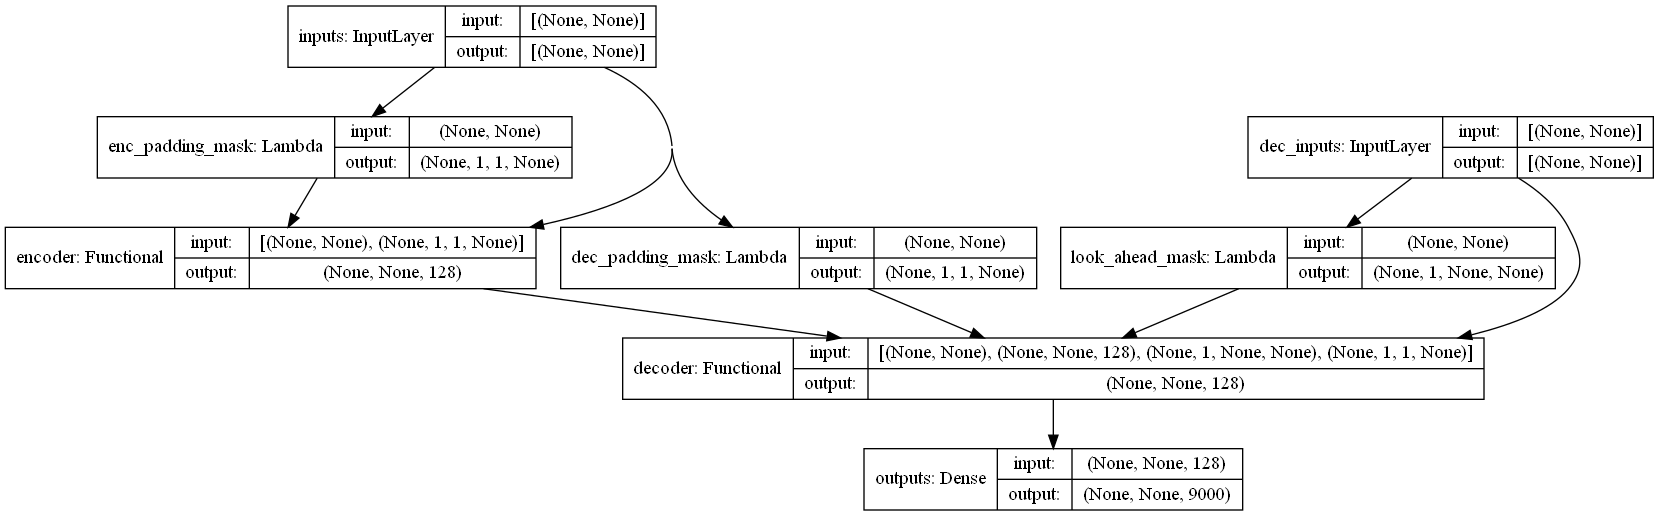

In [21]:
small_transformer = transformer(
    vocab_size = 9000,
    num_layers = 4,
    dff = 512,
    d_model = 128,
    num_heads = 4,
    dropout = 0.3,
    name="small_transformer")

tf.keras.utils.plot_model(
    small_transformer, to_file='small_transformer.png', show_shapes=True)

In [22]:
def loss_function(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))

    loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')(y_true, y_pred)

    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
    loss = tf.multiply(loss, mask)

    return tf.reduce_mean(loss)

Text(0.5, 0, 'Train Step')

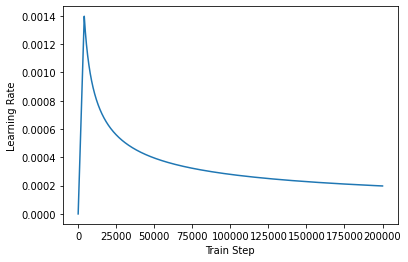

In [23]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()
        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps**-1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")
# Text(0.5, 0, 'Train Step')

### 데이터준비

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import urllib.request
import time
import tensorflow_datasets as tfds
import tensorflow as tf

In [67]:
def read_data():
    line_num = 0
    in_data = []
    out_data = []
    with open('EK_TRANS_DIC.txt', 'r',encoding='utf-8') as fp:
        
        lines = fp.readlines()
        for line in lines:
            line_num += 1
            
            if line_num == 1:
                continue
            line = line.strip().replace("_", " ")
            items = line.strip().split('\t')
            in_data.append(items[0])
            out_data.append(items[1])
            
    return in_data, out_data

questions, answers = read_data()
with open('EK_TRANS_DIC_conv.txt', 'w', encoding='utf-8') as fp:
    for v1, v2 in zip(questions, answers):
        fp.write(f'{v1} | {v2}\n')
        

In [68]:
# 서브워드텍스트인코더를 사용하여 질문, 답변 데이터로부터 단어 집합(Vocabulary) 생성
#tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus( questions + answers, target_vocab_size=2**13)

from tokenizers import BertWordPieceTokenizer

# Initialize an empty BERT tokenizer
tokenizer = BertWordPieceTokenizer(
  clean_text=False,
  handle_chinese_chars=False,
  strip_accents=False,
  lowercase=True,
)

# prepare text files to train vocab on them
files = ['EK_TRANS_DIC_conv.txt']

# train BERT tokenizer
tokenizer.train(
  files,
  vocab_size=100,
  min_frequency=2,
  show_progress=True,
  special_tokens=['[PAD]', '[UNK]', '[CLS]', '[SEP]', '[MASK]'],
  limit_alphabet=1000,
  wordpieces_prefix="##"
)



In [69]:
# 시작 토큰과 종료 토큰에 대한 정수 부여.
#START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]
#VOCAB_SIZE = tokenizer.vocab_size + 2

#For bert tokenizer
START_TOKEN, END_TOKEN = [tokenizer.encode('[CLS]').ids[0]], [btokenizer.encode('[SEP]').ids[0]]
VOCAB_SIZE = tokenizer.get_vocab_size()
VOCAB_SIZE = 2000

In [70]:
print(max(len(q) for q in questions))
print(max(len(a) for a in questions))

226
226


In [71]:
print('시작 토큰 번호 :',START_TOKEN)
print('종료 토큰 번호 :',END_TOKEN)
print('단어 집합의 크기 :',VOCAB_SIZE)


시작 토큰 번호 : [2]
종료 토큰 번호 : [3]
단어 집합의 크기 : 2000


In [72]:
# 최대 길이를 250으로 정의
MAX_LENGTH = 200

# 토큰화 / 정수 인코딩 / 시작 토큰과 종료 토큰 추가 / 패딩
def tokenize_and_filter(inputs, outputs):
    tokenized_inputs, tokenized_outputs = [], []

    for (sentence1, sentence2) in zip(inputs, outputs):
        # encode(토큰화 + 정수 인코딩), 시작 토큰과 종료 토큰 추가
        sentence1 = START_TOKEN + tokenizer.encode(sentence1).ids + END_TOKEN
        sentence2 = START_TOKEN + tokenizer.encode(sentence2).ids + END_TOKEN

        tokenized_inputs.append(sentence1)
        tokenized_outputs.append(sentence2)

    # 패딩
    tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
    tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_outputs, maxlen=MAX_LENGTH, padding='post')

    return tokenized_inputs, tokenized_outputs

questions, answers = tokenize_and_filter(questions, answers)

In [73]:
print('질문 데이터의 크기(shape) :', questions.shape)
print('답변 데이터의 크기(shape) :', answers.shape)

질문 데이터의 크기(shape) : (842881, 200)
답변 데이터의 크기(shape) : (842881, 200)


In [74]:
BATCH_SIZE = 128

BUFFER_SIZE = 20000

# 디코더의 실제값 시퀀스에서는 시작 토큰을 제거해야 한다.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1] # 디코더의 입력. 마지막 패딩 토큰이 제거된다.
    },
    {
        'outputs': answers[:, 1:]  # 맨 처음 토큰이 제거된다. 다시 말해 시작 토큰이 제거된다.
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
# 임의의 샘플에 대해서 [:, :-1]과 [:, 1:]이 어떤 의미를 가지는지 테스트해본다.
print(questions.shape) # 인코더 입력
print(questions[0].shape) # 인코더 입력
print(questions[0])
print(answers[:1][:, :-1]) # 마지막 패딩 토큰 제거하면서 길이가 39가 된다.
print(answers[:1][:, 1:]) # 맨 처음 토큰이 제거된다. 다시 말해 시작 토큰이 제거된다. 길이는 역시 39가 된다.

(842881, 200)
(200,)
[   2   48 1023 1016 1011   37 1011 1081 1016 1014 1017 1016   48 1014
 1008 1005 1010 1011 1074   48 1008 1014 1074 1016 1013   47 1006 1017
 1013 1016 1009    3    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0 

In [75]:
D_MODEL = 256
NUM_LAYERS = 2
NUM_HEADS = 8
DFF = 512
DROPOUT = 0.1

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    dff=DFF,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

(1, 2000, 256)
(1, 2000, 256)


In [76]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  # 레이블의 크기는 (batch_size, MAX_LENGTH - 1)
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

In [77]:
model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 256)    1566208     inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

In [82]:
def evaluate(sentence):
  sentence = preprocess_sentence(sentence)

  sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence).ids + END_TOKEN, axis=0)

  output = tf.expand_dims(START_TOKEN, 0)

  # 디코더의 예측 시작
  for i in range(MAX_LENGTH):
    predictions = model(inputs=[sentence, output], training=False)

    # 현재(마지막) 시점의 예측 단어를 받아온다.
    predictions = predictions[:, -1:, :]
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # 만약 마지막 시점의 예측 단어가 종료 토큰이라면 예측을 중단
    if tf.equal(predicted_id, END_TOKEN[0]):
      break

    # 마지막 시점의 예측 단어를 출력에 연결한다.
    # 이는 for문을 통해서 디코더의 입력으로 사용될 예정이다.
    output = tf.concat([output, predicted_id], axis=-1)

  return tf.squeeze(output, axis=0)
def predict(sentence):
  prediction = evaluate(sentence)

  predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < VOCAB_SIZE])

  print('Input: {}'.format(sentence))
  print('Output: {}'.format(predicted_sentence))

  return predicted_sentence
def preprocess_sentence(sentence):
  sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
  sentence = sentence.strip()
  return sentence



Input: relation heart?
Output: 관계 심장


In [78]:
EPOCHS = 1
model.fit(dataset, epochs=EPOCHS)

6586/6586 [==============================] - 2995s 454ms/step - loss: 0.1358 - accuracy: 0.0150


In [83]:
output = predict("relation heart") #relation heart 관계 심장
output = predict("mobile robot for monitoring and inspection of calandria faces") #mobile robot for monitoring and inspection of calandria faces - 칼란드리아 전면부 검사 이동 로봇

Input: relation heart
Output: 관계 심장
Input: mobile robot for monitoring and inspection of calandria faces
Output: 모바일 소동 모니터링용 이동


In [84]:
EPOCHS = 1
model.fit(dataset, epochs=EPOCHS)
output = predict("relation heart") #relation heart 관계_심장
output = predict("mobile robot for monitoring and inspection of calandria faces") #mobile robot for monitoring and inspection of calandria faces - 칼란드리아 전면부 검사 이동 로봇

6586/6586 [==============================] - 2982s 453ms/step - loss: 0.0506 - accuracy: 0.0269
Input: relation heart
Output: 관계 심장
Input: mobile robot for monitoring and inspection of calandria faces
Output: 모바일용 이동 로봇 모니터링 및 검사


In [85]:
model.save_weights('./tran_word_ckpt')

In [ ]:
EPOCHS = 1
model.fit(dataset, epochs=EPOCHS)
output = predict("relation heart") #relation heart 관계_심장
output = predict("mobile robot for monitoring and inspection of calandria faces") #mobile robot for monitoring and inspection of calandria faces - 칼란드리아 전면부 검사 이동 로봇
model.save_weights('./tran_word_ckpt')

4056/6586 [=================>............] - ETA: 18:58 - loss: 0.0446 - accuracy: 0.0278

In [ ]:
EPOCHS = 1
model.fit(dataset, epochs=EPOCHS)
output = predict("relation heart") #relation heart 관계_심장
output = predict("mobile robot for monitoring and inspection of calandria faces") #mobile robot for monitoring and inspection of calandria faces - 칼란드리아 전면부 검사 이동 로봇